# Estudo pré-Engenharia de Dados

O objetivo desse notebook é fazer algumas verificações em relação ao consumo de memória e tempo de processamento dos jobs de Engenharia de Dados, bem como testar alguns snippets de código e comparar o desempenho de algumas operações de busca/inserção.

Começamos importando as bibliotecas necessárias e configurando o ambiente.

In [2]:
from src.ETL.settings import API_KEY, BASE_URL
import src.ETL.tmdb_api as api
import pandas as pd
from math import ceil
import requests
import json
import locale
from google.oauth2 import service_account
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed


try:
    locale.setlocale(locale.LC_ALL, 'pt_BR')
except:
    locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

# Credenciais BigQuery
credentials = service_account.Credentials.from_service_account_file(
    filename='/home/rodrigo/repos/data-engineering-movies/airflow-docker/dags/src/ETL/credentials.json',
    scopes = ["https://www.googleapis.com/auth/cloud-platform"]
)

endpoint = '/discover/movie'

# Filtros utilizados na busca
params = {
    'primary_release_date.gte': '2023-01-01',
    'primary_release_date.lte': '2023-06-01',
}

def generate_date_intervals(initial_date: str, end_date: str, delta_time: int):
    """
    Generates a list of date intervals between `initial_date` and `end_date` with `delta_time` increments.

    initial_date: str
        'YYYY-mm-dd'
    
    end_date: str
        'YYYY-mm-dd'

    delta_time: int
        in months
    """

    intervals = []

    date_format =  '%Y-%m-%d'
    initial_datetime = datetime.strptime(initial_date, date_format)
    end_datetime = datetime.strptime(end_date, date_format)
    
    current_date = initial_datetime
    while current_date < end_datetime:
        intervals.append((current_date.strftime(date_format), (current_date + relativedelta(months=delta_time)).strftime(date_format)))
        current_date += relativedelta(months=delta_time)
    return intervals


Nosso objetivo é consultar o endpoint _**/discover/movie**_ da API do TMDB. Esse endpoint nos permite fazer queries na base de dados, paginando os resultados. Cada página possui informações sobre 20 filmes, e, para uma dada query, podemos pegar qualquer página entre 1 e 1000 de forma independente. 

Façamos então uma primeira query ingênua, sem filtro algum:

In [3]:

def make_discover_request(page=1, params={}):
    params['page'] = page

    default_params = {
        "api_key": API_KEY,
        'language': 'pt-br'
    }
    
    default_params.update(params)
    return json.loads(
        requests.get(BASE_URL + endpoint, params=default_params).content.decode()
    )

response = make_discover_request()

In [4]:
pages = response['total_pages']
print(f'Há um total de {pages} páginas para a busca ingênua, o que dá aproximadamente {20 * pages} filmes')

Há um total de 38128 páginas para a busca ingênua, o que dá aproximadamente 762560 filmes


São MUITAS páginas de resultado. Isso não nos é útil, dado que a API nos permite somente pegar os resultados que estejam no intervalo de páginas de 1 a 1000.

Mudemos então nossa estratégia. Utilizaremos o filtro de data, quebrando a base de dados em vários conjuntos disjuntos, e faremos a integração desses conjuntos. 

Exemplo: Primeiro integrar todos os filmes que foram lançados em 2023; depois, os de 2022; depois, 2021, e por aí vai. Será que isso funciona? Façamos então uma nova query para analisar se essa solução é viável.


In [5]:
params = {
    'primary_release_date.gte': '2013-01-01',
    'primary_release_date.lte': '2023-01-01',
}

make_discover_request(params=params)['total_pages']

13440

Para um período de 10 anos, temos mais que 10 mil páginas. Pelo Princípio das Casas de Pombo, segue que pelo menos um ano possui mais de mil páginas de filmes. Isso não nos é interessante, dado que podemos pegar as informações até a milésima página.

Façamos uma visualização da quantidade de filmes por década para termos uma melhor ideia da situação:

In [6]:
date_intervals = generate_date_intervals('1930-01-01', '2030-01-01', 120)

decades = list()
qt_movies = list()

for date_interval in date_intervals:
    response = make_discover_request(params={
        'primary_release_date.gte': date_interval[0],
        'primary_release_date.lte': date_interval[1],
    })

    decades.append(date_interval[0][:4])
    qt_movies.append(response['total_results'])

## Primeira Visualização

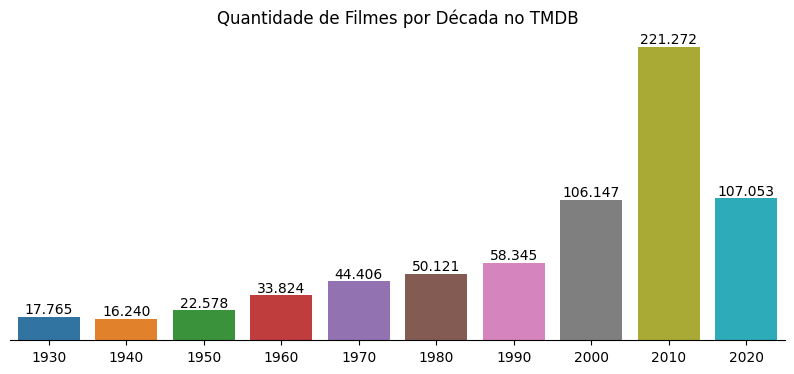

In [7]:
plot = sns.barplot(x=decades, y=qt_movies)
sns.despine(top=True, left=True)

for i, v in enumerate(qt_movies):
    plt.annotate(f"{v:_.0f}".replace('_', '.'), xy=(i, v), ha='center', va='bottom')

plt.title('Quantidade de Filmes por Década no TMDB')

# Retira graduação do eixo Y
plot.yaxis.set_ticks([])

# Aumenta largura
fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.show()


# Teste de ingestão

Vamos pegar dados sobre filmes do primeiro semestre de 2018 como um exemplo.

In [8]:
params = {
    'primary_release_date.gte': '2018-01-01',
    'primary_release_date.lte': '2018-07-01',
}

response = make_discover_request(params = params)

In [9]:
response['total_pages'], response['total_results']

(705, 14095)

In [10]:
def pega_resultados_de_intervalo_de_paginas(inicio: int, fim: int, params: dict) -> pd.DataFrame:
    results = []
    for page in range(inicio, fim):
        response = make_discover_request(page, params=params)
        if 'results' not in response:
            print('Deu ruim, não tem resultados')
            print(page)
            print(response)
            continue

        results.extend(response['results'])
    
    return pd.DataFrame(results)

def gera_intervalos(inicio, fim, qt_intervalos):
    tamanho_intervalo = ceil((fim - inicio) / qt_intervalos)
    intervalos = [(i, i + tamanho_intervalo) for i in range(inicio, fim, tamanho_intervalo)]

    if intervalos[-1][1] > fim:
        x = intervalos.pop()
        intervalos.append((x[0], fim))
    return intervalos


In [11]:
params = {
    'primary_release_date.gte': '2018-01-01',
    'primary_release_date.lte': '2018-03-01',
}

response = make_discover_request(params = params)

print('Total de páginas:', response['total_pages'])
intervalos_pags = gera_intervalos(1, response['total_pages'] +1, 4)

print('Pegaremos os dados nos intervalos', intervalos_pags)
# Paraleliza processamento
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(pega_resultados_de_intervalo_de_paginas, intervalo[0], intervalo[1], params) for intervalo in intervalos_pags]
    resultados = []
    for future in as_completed(futures):
        # Obtém o resultado do objeto Future
        df_resultado = future.result()

        # Adiciona o resultado à lista de resultados
        resultados.append(df_resultado)

Total de páginas: 274
Pegaremos os dados nos intervalos [(1, 70), (70, 139), (139, 208), (208, 275)]


In [12]:
df_final = pd.concat(resultados, ignore_index=True)

In [13]:
print(response['total_results'])
df_final.info()

5467
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5467 entries, 0 to 5466
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              5467 non-null   bool   
 1   backdrop_path      1851 non-null   object 
 2   genre_ids          5467 non-null   object 
 3   id                 5467 non-null   int64  
 4   original_language  5467 non-null   object 
 5   original_title     5467 non-null   object 
 6   overview           5467 non-null   object 
 7   popularity         5467 non-null   float64
 8   poster_path        4568 non-null   object 
 9   release_date       5467 non-null   object 
 10  title              5467 non-null   object 
 11  video              5467 non-null   bool   
 12  vote_average       5467 non-null   float64
 13  vote_count         5467 non-null   int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 523.3+ KB


Podemos observar que o dataframe resultante possui todos os dados referentes aos filmes no intervalo definido e consome somente 524 KB de memória. Estamos lidando portanto com um baixo volume de dados. O maior problema é em relação à API: traz pouquíssimos dados por vez (20 entradas por requisição) e demora muito (cerca de 600 ms por requisição).

A paralelização deve ajudar, diminuindo o tempo total necessário para ingerir os dados. O código aqui escrito deve dar uma boa base para implementação de uma pipeline paralelizada e eficiente.

Uma vez que tenhamos consumido a API e pegado os dados, vamos ver o que podemos fazer com eles.

In [16]:
df_final.head()

df_to_tmdb = df_final.drop(['genre_ids', 'backdrop_path', 'overview', 'vote_average', 'vote_count'], axis=1)

In [36]:
many_to_many = df_final[['id', 'genre_ids']]

In [37]:
many_to_many.explode('genre_ids').dropna(axis=0)


,id,genre_ids
0,890947,18
1,888293,36
1,888293,10770
1,888293,18
2,881213,35
...,...,...
5463,946667,14
5464,921922,28
5464,921922,9648
5466,917486,18


Assim conseguimos criar o código que gerará as entradas na tabela many-to-many.